In [13]:
import random
import string

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence


In [14]:
device = "cpu"
device

'cpu'

In [15]:
allowed_chars = string.digits + '+' + 'b' + 'p' + 'e'
eos_token_id = allowed_chars.index("e") 
padding_token_id = allowed_chars.index("p")


class Generator:
    def __init__(self) -> None:
        pass

    def sample(self):
        s1 = random.randint(100, 99999)
        s2 = random.randint(100, 99999)
        r = s1 + s2
        input = f"{s1}+{s2}e"
        output = f"b{r}e"
        return self.string_to_tensor(input), self.string_to_tensor(output)

    def batch(self, n):
        inputs = []
        outputs = []
        for _ in range(n):
            input, output = self.sample()
            inputs.append(input)
            outputs.append(output)
        return inputs, outputs

    def string_to_tensor(self, s):
        tensor = torch.zeros(len(s), len(allowed_chars))
        for i, char in enumerate(s):
            tensor[i, allowed_chars.index(char)] = 1
        return tensor

    def tensor_to_string(self, tensor):
        _, max_idx = tensor.max(1)
        return ''.join([allowed_chars[i] for i in max_idx])

    def batch_to_tensor(self, n):
        seq_in = []
        seq_out = []
        inputs, outputs = self.batch(n)
        for input, output in zip(inputs, outputs):
            seq_in.append(input)
            seq_out.append(output)
        return pad_sequence(seq_in, batch_first=True), pad_sequence(seq_out, batch_first=True)

In [16]:
import torch.nn as nn


class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)
        self.eos_token_id = eos_token_id
        self.pad_token_id = padding_token_id
        self.max_length = 8

    def forward(self, input, hidden=None):
        _, (hn_enc, cn_enc) = self.encoder(input, hidden)
        output_seq = []
        decoder_input = hn_enc[0].unsqueeze(1) 
        for _ in range(self.max_length):
            out_dec, (hn_dec, cn_dec) = self.decoder(decoder_input, (hn_enc, cn_enc))
            decoder_output = self.output(out_dec[:, -1, :])
            output_seq.append(decoder_output.unsqueeze(1))
            if (decoder_output.argmax(dim=1) == self.eos_token_id).all(): break
            decoder_input = out_dec
            hn_enc, cn_enc = hn_dec, cn_dec
        if len(output_seq) < self.max_length:
            output_seq.append(torch.full((input.size(0), self.max_length - len(output_seq), self.output.out_features), self.pad_token_id))
        return torch.cat(output_seq, dim=1)

In [17]:
model = Seq2Seq(input_size=len(allowed_chars), hidden_size=128, output_size=len(allowed_chars))
model.to(device)

Seq2Seq(
  (encoder): LSTM(14, 128, batch_first=True)
  (decoder): LSTM(128, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=14, bias=True)
)

Epoch: 0, Loss: 0.07249941676855087
Epoch: 100, Loss: 17.959321975708008
Epoch: 200, Loss: 0.04080992564558983
Epoch: 300, Loss: 0.0400722436606884
Epoch: 400, Loss: 0.03907400742173195
Epoch: 500, Loss: 0.03743079677224159
Epoch: 600, Loss: 0.036634646356105804
Epoch: 700, Loss: 0.03638758882880211
Epoch: 800, Loss: 0.036828167736530304
Epoch: 900, Loss: 0.036024581640958786
Epoch: 1000, Loss: 0.034529488533735275
Epoch: 1100, Loss: 0.03491681069135666
Epoch: 1200, Loss: 0.03359894081950188
Epoch: 1300, Loss: 0.034902118146419525
Epoch: 1400, Loss: 0.03425104171037674
Epoch: 1500, Loss: 0.03335794433951378
Epoch: 1600, Loss: 0.03369618579745293
Epoch: 1700, Loss: 0.03298008441925049
Epoch: 1800, Loss: 0.0335463248193264
Epoch: 1900, Loss: 0.03393164277076721
Epoch: 2000, Loss: 0.032813213765621185
Epoch: 2100, Loss: 0.03316207975149155
Epoch: 2200, Loss: 0.0328516811132431
Epoch: 2300, Loss: 0.03260918706655502
Epoch: 2400, Loss: 0.03380521759390831
Epoch: 2500, Loss: 0.03324270993471

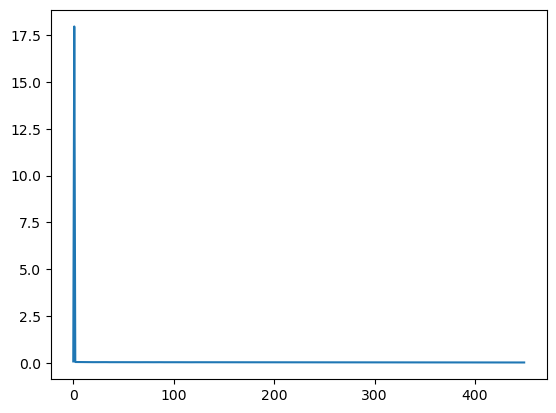

In [18]:
history = []

def train(model, optimizer, loss_fn, n_epochs, batch_size):
    for epoch in range(n_epochs):
        total_loss = 0
        optimizer.zero_grad()
        x, y = dg.batch_to_tensor(batch_size)
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if epoch % 100 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, total_loss))
            history.append(total_loss)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

dg = Generator()
train(model, optimizer, loss_fn, 45_000, 128)
plt.plot(history, label='loss')

In [135]:
def evaluate(model, n):
    x, y = dg.batch_to_tensor(n)
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    for i in range(n):
        print(dg.tensor_to_string(x[i]), dg.tensor_to_string(y_pred[i]), dg.tensor_to_string(y[i]))

evaluate(model, 10)

23135+70522e b93664e1 b93657e0
98797+61492e b160291e b160289e
17445+22981e b40420e1 b40426e0
52320+87110e b139420e b139430e
69372+85606e b154974e b154978e
29260+82774e b112032e b112034e
11727+75608e b87330e1 b87335e0
84789+65730e b150511e b150519e
76711+76679e b153391e b153390e
4126+87640e0 b91771e1 b91766e0
